In [223]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [224]:
def add_noise(y_base, low=0, high=0.2):
  # Random signs (-1 or 1)
  signs = torch.where(torch.rand(y_base.shape) > 0.5, 1.0, -1.0)

  # Random scale within bounds
  scales = torch.rand(y_base.shape) * (high - low) + low

  return signs * scales * y_base

SSR: 123.9533


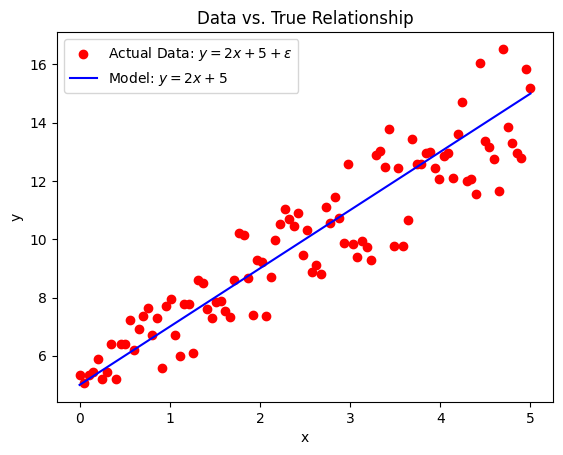

In [225]:
_ = torch.manual_seed(5)
x = torch.linspace(0, 5, 100)

# Underlying true relationship: y = 2x + 5
true_beta1 = 2
true_beta0 = 5

# Add Noise (ε)
y_base = true_beta1 * x + true_beta0
noise = add_noise(y_base)
y = y_base + noise

# Model Prediction (using known parameters)
y_pred = true_beta1 * x + true_beta0
ssr = torch.sum((y - y_pred) ** 2)
print(f"SSR: {ssr:.4f}")

# Plotting
_ = plt.scatter(x, y, color='red', label=r'Actual Data: $y = 2x + 5 + \epsilon$')
_ = plt.plot(x, y_pred, label=f'Model: $y = {true_beta1}x + {true_beta0}$', color='blue')
_ = plt.title('Data vs. True Relationship')
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.legend()

## Analytical Best Fit
We use numpy.polyfit() to find the optimal coefficients analytically via Ordinary Least Squares (OLS).

This gives us the "ground truth" best fit line, which we will later aim to reach using iterative Gradient Descent.

SSR: 114.5550
Learned Equation: y = 1.81x + 5.35


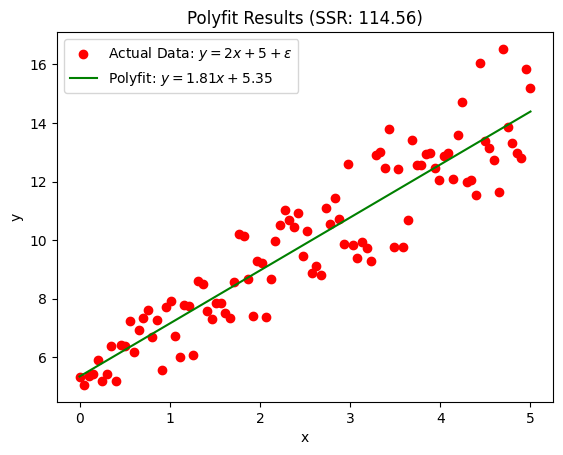

In [226]:
# Model Training
# deg=1 for linear regression (y = mx + b)
m, b = np.polyfit(x, y, deg=1)

# Prediction & Metrics
y_pred = m * x + b
ssr = torch.sum((y - y_pred) ** 2)
print(f"SSR: {ssr:.4f}")
print(f"Learned Equation: y = {m:.2f}x + {b:.2f}")

# Plotting
_ = plt.scatter(x, y, color='red', label=r'Actual Data: $y = 2x + 5 + \epsilon$')
_ = plt.plot(x, y_pred, color='green', label=f'Polyfit: $y = {m:.2f}x + {b:.2f}$')
_ = plt.title(f'Polyfit Results (SSR: {ssr:.2f})')
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.legend()

## Moving on to Gradient Descent

In [227]:
X = x.reshape(-1, 1)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([100, 1])
y shape: torch.Size([100])


## Train test splitting

In [228]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_size
test_size

80

20

X_train shape: torch.Size([80, 1]), y_train shape: torch.Size([80])
X_test shape: torch.Size([20, 1]), y_test shape: torch.Size([20])


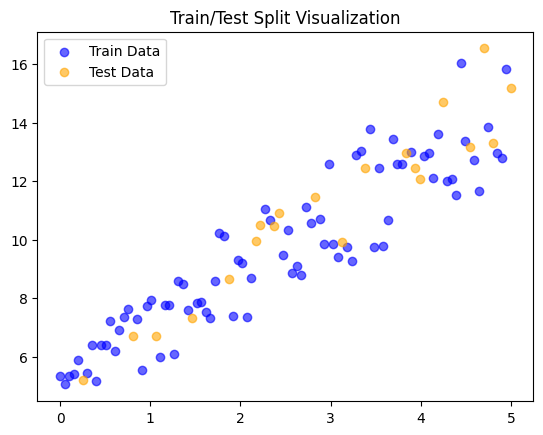

In [229]:
indices = torch.randperm(len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Visualize the split to ensure coverage
_ = plt.scatter(X_train, y_train, color='blue', label='Train Data', alpha=0.6)
_ = plt.scatter(X_test, y_test, color='orange', label='Test Data', alpha=0.6)
_ = plt.legend()
_ = plt.title("Train/Test Split Visualization")

## Data Loading Strategy

In [230]:
batch_size = 16

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# DataLoaders
# Shuffling the training data is crucial for Gradient Descent
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Shuffling test data isn't necessary, but we keep batching for consistency
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


# Quick check on a single batch
features, targets = next(iter(train_loader))
print(f"Batch features shape: {features.shape}")
print(f"Batch targets shape: {targets.shape}")

Batch features shape: torch.Size([16, 1])
Batch targets shape: torch.Size([16])


## Model Construction

In [231]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initialize weights (ß1) and bias (ß0) with random values
    # We use nn.Parameter so PyTorch knows to track these for gradient descent
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True))

  def forward(self, x):
    # The forward pass: y = mx + b
    return self.weights * x + self.bias

In [232]:
_ = torch.manual_seed(42)
model = LinearRegressionModel()
model

print("Initial Parameters:")
print(f"Weights: {model.weights.item():.4f}")
print(f"Bias: {model.bias.item():.4f}")

LinearRegressionModel()

Initial Parameters:
Weights: 0.3367
Bias: 0.1288


In [233]:
for name, param in model.named_parameters():
  print(f'{name}')
  print(f'{param}\n')

weights
Parameter containing:
tensor([0.3367], requires_grad=True)

bias
Parameter containing:
tensor([0.1288], requires_grad=True)



In [234]:
with torch.no_grad():  # same as model.inference_mode()
  y_pred = model(X_test)

((y_test - y_pred) ** 2).sum()
((y_test - y_pred) ** 2).mean()

tensor(42842.5664)

tensor(107.1064)

## Custom Loss Construction

In [235]:
class MeanSquaredError(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)  # MSE

In [236]:
mse_loss = MeanSquaredError()

# Create dummy tensors to test
y_true = torch.tensor([1.0, 2.0, 3.0])
y_pred = torch.tensor([1.5, 2.5, 3.5])

loss = mse_loss(y_pred, y_true)
print(f"Calculated Loss: {loss.item():.4f}")

Calculated Loss: 0.2500


## Initial Test Loss

Initial Test Loss: 107.1064


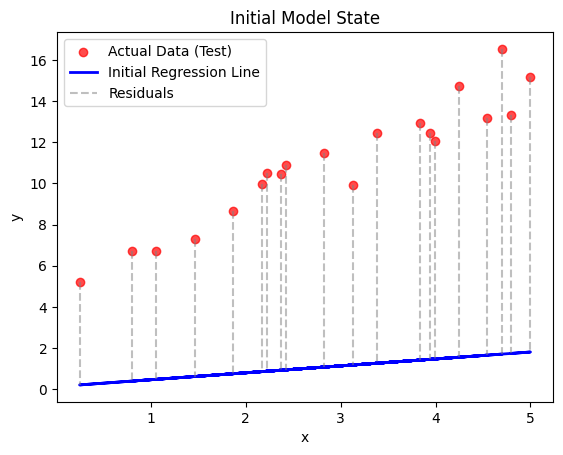

In [237]:
with torch.inference_mode():
  y_test_pred = model(X_test)
  initial_loss = mse_loss(y_test_pred, y_test)

print(f"Initial Test Loss: {initial_loss.item():.4f}")

# Actual Test Data
_ = plt.scatter(X_test, y_test, color='red', label='Actual Data (Test)', alpha=0.7)

# Model Prediction Line
_ = plt.plot(X_test, y_test_pred, color='blue', label='Initial Regression Line', linewidth=2)

# Residuals
_ = plt.vlines(X_test, y_test, y_test_pred, color='gray',
               linestyle='--', alpha=0.5, label='Residuals')
_ = plt.title(f"Initial Model State")
_ = plt.xlabel("x")
_ = plt.ylabel("y")
_ = plt.legend()

## Model Training and Optimization

In [238]:
learning_rate = 0.01

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Loss Function: {loss_fn}\n")
print(f"Optimizer: {optimizer}")

Loss Function: MSELoss()

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## The Training Loop

In [239]:
epochs = 300

# Initial loss
_ = model.eval()
with torch.inference_mode():
  initial_y_pred = model(X_train).squeeze()
  initial_loss = loss_fn(initial_y_pred, y_train)
  print(f"Initial Training Loss: {initial_loss.item():.4f}")
  print("-" * 30)

_ = model.train()

for epoch in range(1, epochs+1):

  for X_batch, y_batch in train_loader:
    # 1. forward pass
    y_pred = model(X_batch).squeeze()

    # 2. calc loss
    loss = loss_fn(y_batch, y_pred)

    # 3. reset gradients
    optimizer.zero_grad()

    # 4. backward pass
    loss.backward()

    # 5. update params
    optimizer.step()

  # Print progress every 10 epochs
  if epoch % 100 == 0 or epoch == 1:
    print(f"Epoch: {epoch:3d} | Loss: {loss.item():.4f}")

Initial Training Loss: 80.0766
------------------------------
Epoch:   1 | Loss: 24.3842
Epoch: 100 | Loss: 1.1736
Epoch: 200 | Loss: 1.0929
Epoch: 300 | Loss: 1.5123


Learned Equation: y = 1.73x + 5.42
Final Test Loss: 1.2205


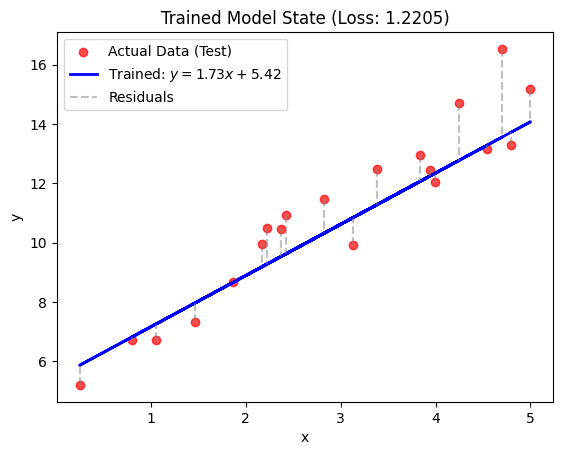

In [240]:
m_learned = model.weights.item()
b_learned = model.bias.item()

print(f"Learned Equation: y = {m_learned:.2f}x + {b_learned:.2f}")

with torch.inference_mode():
  y_test_pred = model(X_test).squeeze()
  final_loss = loss_fn(y_test_pred, y_test)

print(f"Final Test Loss: {final_loss.item():.4f}")

# Actual Test Data
_ = plt.scatter(X_test, y_test, color='red', label='Actual Data (Test)', alpha=0.7)

# Model Prediction Line
_ = plt.plot(X_test, y_test_pred, color='blue',
             label=f'Trained: $y = {m_learned:.2f}x + {b_learned:.2f}$', linewidth=2)

# Residuals
_ = plt.vlines(X_test, y_test, y_test_pred, color='gray',
               linestyle='--', alpha=0.5, label='Residuals')

_ = plt.title(f"Trained Model State (Loss: {final_loss.item():.4f})")
_ = plt.xlabel("x")
_ = plt.ylabel("y")
_ = plt.legend()

In [241]:
m, b = np.polyfit(x, y, deg=1)
y_pred = m * x + b
loss = torch.mean((y - y_pred) ** 2)

print(f"Analytical (Polyfit) Results")
print(f"Equation: y = {m:.2f}x + {b:.2f}")
print(f"MSE: {loss:.4f}")

print(f"\nGradient Descent Results")
print(f"Equation: y = {m_learned:.2f}x + {b_learned:.2f}")
print(f"MSE: {final_loss.item():.4f}")

Analytical (Polyfit) Results
Equation: y = 1.81x + 5.35
MSE: 1.1456

Gradient Descent Results
Equation: y = 1.73x + 5.42
MSE: 1.2205
